# Validation

In [1]:
# import libraries
import os
import ROOT
import numpy as np
from scipy import stats

Welcome to JupyROOT 6.18/00


In [2]:
# color palette
blue = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 31., 119., 180.)
orange = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 255., 127., 14.)
green = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 44., 160., 44.)
red = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 214., 39., 40.)
purple = ROOT.TColor(ROOT.TColor.GetFreeColorIndex(), 148., 103., 189.)
palette = {'blue': blue, 'orange': orange, 'green': green, 'red': red, 'purple': purple}

## 0. Create dataframes

In [3]:
# helpers
def leakageCorrection(col):
    return f"{col}*PrimaryEnergy/(PrimaryEnergy-LateralLeakage)"

def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

In [4]:
treeName = "B4"
path = "/groups/hep/mojen/repositories/DREAM/Run/final_validation/brass_copy/"

In [11]:
# create rdataframe

fileName = os.path.join(path, "electron_100GeV/electron_100GeV.root")
rdf = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
# define new columns
rdf = rdf.Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
rdf = rdf.Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov" ))
rdf = rdf.Define("Ssum", "Sum(VecSignalScnt_corr)")
rdf = rdf.Define("Csum", "Sum(VecSignalCkov_corr)")

TypeError: can not resolve method template call for 'Define'

Error in <TFile::TFile>: file /groups/hep/mojen/repositories/DREAM/Run/final_validation/brass_copy/electron_100GeV/electron_100GeV.root does not exist
Error in <TFile::TFile>: file /groups/hep/mojen/repositories/DREAM/Run/final_validation/brass_copy/electron_100GeV/electron_100GeV.root does not exist


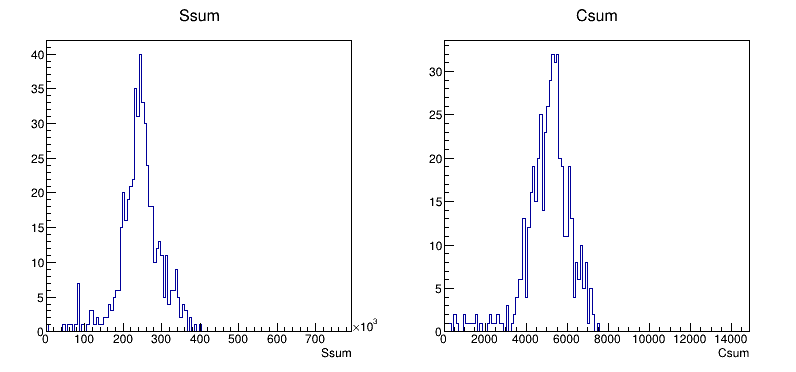

In [37]:
c1 = ROOT.TCanvas("c", "c", 800, 400)
c1.Divide(2)
c1.cd(1)
# model = ("", "", 100, 0., 2000.)
h1a = rdf.Filter("PrimaryPDG == 11").Histo1D("Ssum")
h1b = rdf.Filter("PrimaryPDG == -211").Histo1D("Ssum")
h1a.Draw()
h1b.SetLineColor(ROOT.kRed)
h1b.Draw("SAME")
c1.cd(2)
h2a = rdf.Filter("PrimaryPDG == 11").Histo1D("Csum")
h2b = rdf.Filter("PrimaryPDG == -211").Histo1D("Csum")
h2a.Draw()
h2b.SetLineColor(ROOT.kRed)
h2b.Draw("SAME")
c1.Draw()

## 1. Calibration

### 50 GeV electrons -> S_cal, C_cal

In [38]:
rdf_cal = rdf.Filter("PrimaryPDG == 11", "electron")
rdf_cal_S = rdf_cal.Filter("Ssum > 0.", "Cut1").Define("Snorm", "PrimaryEnergy/Ssum")
rdf_cal_C = rdf_cal.Filter("Csum > 0.", "Cut1").Define("Cnorm", "PrimaryEnergy/Csum")
# modified Z score
rdf_cal_S = rdf_cal_S.Filter(modifiedZscore(rdf_cal_S, "Snorm"), "Cut2")
rdf_cal_C = rdf_cal_C.Filter(modifiedZscore(rdf_cal_C, "Cnorm"), "Cut2")
# print cuts report
cutsReport_S = rdf_cal_S.Report()
cutsReport_S.Print()
cutsReport_C = rdf_cal_C.Report()
cutsReport_C.Print()

electron  : pass=500        all=500        -- eff=100.00 % cumulative eff=100.00 %
Cut1      : pass=499        all=500        -- eff=99.80 % cumulative eff=99.80 %
Cut2      : pass=473        all=499        -- eff=94.79 % cumulative eff=94.60 %
electron  : pass=500        all=500        -- eff=100.00 % cumulative eff=100.00 %
Cut1      : pass=499        all=500        -- eff=99.80 % cumulative eff=99.80 %
Cut2      : pass=473        all=499        -- eff=94.79 % cumulative eff=94.60 %


0.4083659434202771 19.575867001640727
 FCN=61.4701 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=3.21047e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.46209e+01   1.01580e+00   2.78145e-03  -3.21975e-05
   2  Mean         4.01376e-01   3.56965e-03   1.37470e-05  -6.48168e-02
   3  Sigma        6.77251e-02   3.76892e-03   5.03140e-05  -6.26716e-03
 FCN=76.9777 FROM MIGRAD    STATUS=CONVERGED      83 CALLS          84 TOTAL
                     EDM=2.5423e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.45122e+01   1.03231e+00   3.14448e-03   1.73732e-05
   2  Mean         1.90236e+01   1.62842e-01   6.95907e-04   1.07225e

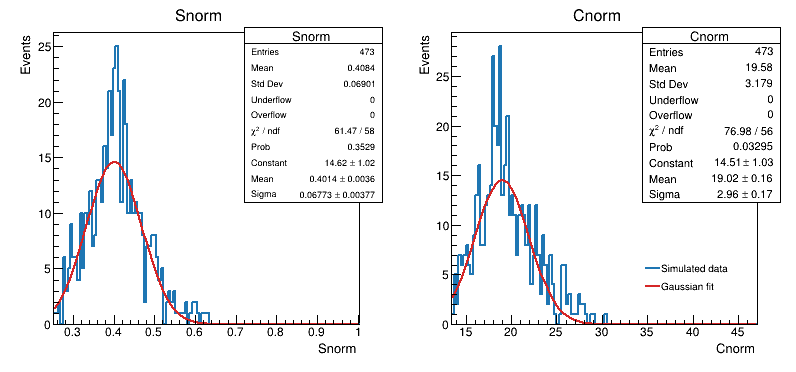

In [39]:
c1 = ROOT.TCanvas("c", "c", 800, 400)
c1.Divide(2)
col = ["Snorm", "Cnorm"]
d = [rdf_cal_S, rdf_cal_C]
h = [None, None]
mean = [None, None]
for i in range(len(col)):
    c1.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c1.Draw()

S_cal = mean[0]
C_cal = mean[1]

S_cal = rdf_cal_S.Mean("Snorm").GetValue()
C_cal = rdf_cal_C.Mean("Cnorm").GetValue()
print(S_cal, C_cal)

### 50 GeV pions -> chi

NB! Should use S_cal, C_cal on new independent data which is not done here

In [8]:
rdf_chi = rdf
rdf_chi = rdf_chi.Define("Ssum_cal", f"Ssum*{S_cal}")
rdf_chi = rdf_chi.Define("Csum_cal", f"Csum*{C_cal}")
rdf_chi = rdf_chi.Define("CoverS", "Csum_cal/Ssum_cal")
rdf_chi = rdf_chi.Define("Snorm_cal", "Ssum_cal/PrimaryEnergy")
rdf_chi = rdf_chi.Define("Cnorm_cal", "Csum_cal/PrimaryEnergy")
rdf_chi = rdf_chi.Define("chi", "(1-Snorm_cal)/(1-Cnorm_cal)")

In [9]:
rdf_chi_pi = rdf_chi.Filter("PrimaryPDG == -211", "pion")
# modified Z score
rdf_chi_pi = rdf_chi_pi.Filter(modifiedZscore(rdf_chi, "chi"), "Cut2")
# print cuts report
cutsReport_chi_pi = rdf_chi_pi.Report()
cutsReport_chi_pi.Print()

pion      : pass=50         all=100        -- eff=50.00 % cumulative eff=50.00 %
Cut2      : pass=50         all=50         -- eff=100.00 % cumulative eff=50.00 %


 FCN=7.14684 FROM MIGRAD    STATUS=CONVERGED      94 CALLS          95 TOTAL
                     EDM=1.47079e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.51982e+00   2.92739e-01   3.23444e-04  -7.33933e-04
   2  Mean         5.11798e-01   1.69761e-01   2.36535e-04   1.72426e-03
   3  Sigma        4.59086e-01   3.03946e-01   4.33211e-04   6.78140e-04


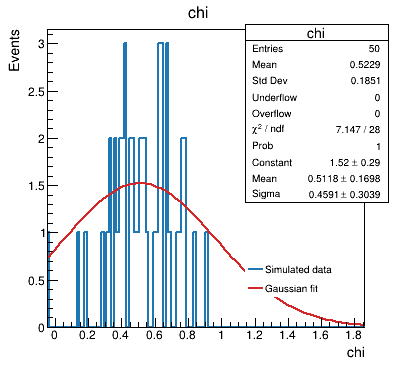

In [10]:
c2 = ROOT.TCanvas("c", "c", 400, 400)
col = ["chi"]
d = [rdf_chi_pi]
h = [None]
mean = [None]
for i in range(len(col)):
    c2.cd(i+1)
    ROOT.gStyle.SetOptStat("nemr ou")
    ROOT.gStyle.SetOptFit(1111)
    ROOT.gPad.SetLeftMargin(0.12)
    ROOT.gPad.SetBottomMargin(0.12)
    ROOT.gPad.SetRightMargin(0.08)
    ROOT.gPad.SetTopMargin(0.08)
    h[i] = d[i].Histo1D(col[i])
    h[i].GetXaxis().SetTitle(col[i])
    h[i].GetXaxis().SetTitleSize(0.04)
    h[i].GetYaxis().SetTitle("Events")
    h[i].GetYaxis().SetTitleSize(0.04)
    h[i].DrawCopy("E1")
    r = h[i].Fit("gaus", "S")
    h[i].SetLineColor(palette['blue'].GetNumber())
    h[i].SetLineWidth(2)
    gaus = h[i].GetFunction("gaus")
    gaus.SetLineColor(palette['red'].GetNumber())
    gaus.SetLineWidth(2)
    mean[i] = r.Parameter(1)
    rms = r.Parameter(2)
    # add legend
    legend = ROOT.TLegend(0.62, 0.2, 0.82, 0.3)
    legend.SetFillColor(0)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.03)
    legend.AddEntry(h[i].GetValue(), "Simulated data", "l")
    legend.AddEntry(gaus, "Gaussian fit", "l")
    legend.Draw()
    
ROOT.gPad.Modified()
ROOT.gPad.Update()
c2.Draw()

chi = mean[0]

## 2. Performance

### Energy resolution

In [11]:
rdf_energy = rdf_chi
rdf_energy_e = rdf_energy.Filter("PrimaryPDG == 11", "electron")
rdf_energy_pi = rdf_energy.Filter("PrimaryPDG == -211", "pion")
# modified Z score
rdf_energy_pi = rdf_energy_pi.Filter(modifiedZscore(rdf_energy_pi, "Snorm_cal")+"&&"+modifiedZscore(rdf_energy_pi, "Cnorm_cal"), "Cut2")
# print cuts report
cutsReport_energy = rdf_energy_pi.Report()
cutsReport_energy.Print()

pion      : pass=50         all=100        -- eff=50.00 % cumulative eff=50.00 %
Cut2      : pass=48         all=50         -- eff=96.00 % cumulative eff=48.00 %


In [12]:
# correlation coefficients
SC_e = rdf_energy_e.AsNumpy(columns=["Snorm_cal", "Cnorm_cal"])
SC_pi = rdf_energy_pi.AsNumpy(columns=["Snorm_cal", "Cnorm_cal"])
print(stats.pearsonr(x=SC_e['Snorm_cal'], y=SC_e['Cnorm_cal']))
print(stats.pearsonr(x=SC_pi['Snorm_cal'], y=SC_pi['Cnorm_cal']))

(0.34241490875149494, 0.01492969296669148)
(0.8726878971203889, 6.357107580545599e-16)


In [13]:
# rotation method
gr = rdf_energy_pi.Graph("Snorm_cal", "Cnorm_cal")
# linear fit
r = gr.Fit("pol1", "S")


****************************************
Minimizer is Linear
Chi2                      =     0.369514
NDf                       =           46
p0                        =     -0.29739   +/-   0.0657543   
p1                        =      1.07703   +/-   0.0888497   


In [14]:
p0 = r.Parameter(0)
p1 = r.Parameter(1)
X = p0/(1-p1)
theta = np.pi/2 - np.arctan(p1)
print(p0, p1, X, theta*180/np.pi)

-0.29739031665872734 1.0770266359377163 3.8608763454137733 42.876156455976805


In [15]:
rotate_xcoord_code = '''
double rotate_xcoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return x;
};
'''
ROOT.gInterpreter.Declare(rotate_xcoord_code)
rotate_ycoord_code = '''
double rotate_ycoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return y;
};
'''
ROOT.gInterpreter.Declare(rotate_ycoord_code)

True

In [16]:
rdf_energy_pi = rdf_energy_pi.Define("PivotPoint", str(X))
rdf_energy_pi = rdf_energy_pi.Define("PivotAngle", str(theta))
rdf_energy_pi = rdf_energy_pi.Define("Snorm_cal_rot", "rotate_xcoord(Snorm_cal, Cnorm_cal, PivotAngle, PivotPoint)")
rdf_energy_pi = rdf_energy_pi.Define("Cnorm_cal_rot", "rotate_ycoord(Snorm_cal, Cnorm_cal, PivotAngle, PivotPoint)")

 FCN=6.73253 FROM MIGRAD    STATUS=CONVERGED     126 CALLS         127 TOTAL
                     EDM=9.4313e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.31951e+00   2.68143e-01   2.78786e-04  -3.96446e-05
   2  Mean         3.85700e+00   9.20446e-02   1.24999e-04  -4.43549e-04
   3  Sigma        1.89113e-01   2.08554e-01   8.96481e-04  -1.56975e-04


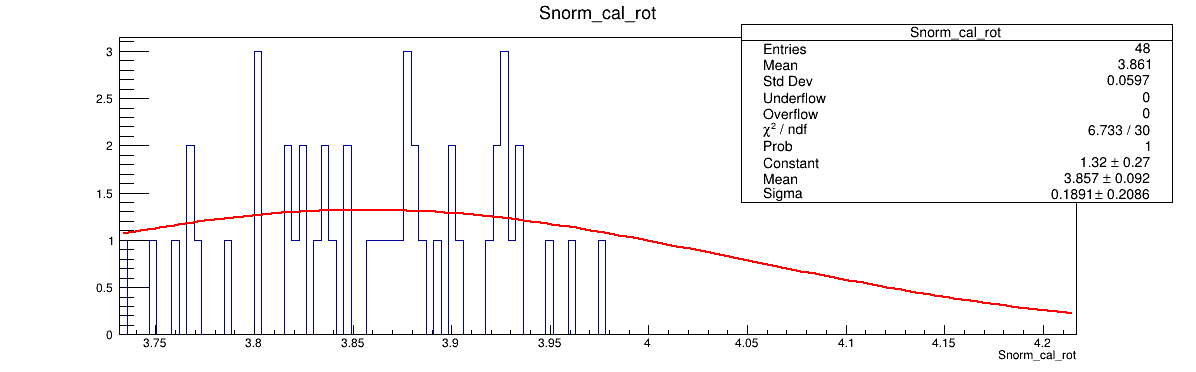

In [17]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf_energy_pi.Histo1D("Snorm_cal_rot")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [18]:
# C/E vs S/E
gr1 = rdf_energy_e.Graph("Snorm_cal", "Cnorm_cal")
gr2 = rdf_energy_pi.Graph("Snorm_cal", "Cnorm_cal")
gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

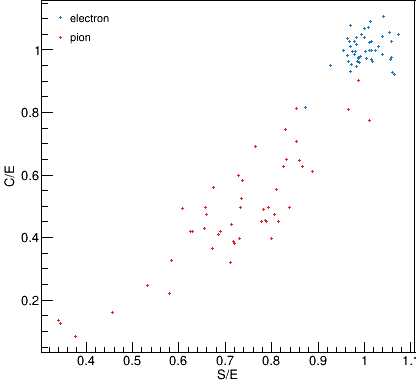

In [19]:
ratio = 7/3
nbins = 40
c1 = ROOT.TCanvas("c1", "c1", 420, 420)
c1.SetRightMargin(0.)
c1.SetTopMargin(0.)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
mg.Draw("ap")
mg.GetXaxis().SetTitle("S/E")
mg.GetYaxis().SetTitle("C/E")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
# add legend
legend = ROOT.TLegend(0.12, 0.88, 0.32, 0.98)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.AddEntry(gr1.GetValue(), "electron", "p")
legend.AddEntry(gr2.GetValue(), "pion", "p")
legend.Draw()
c1.Draw()
c1.Print("hXY.png")

 FCN=11.1063 FROM MIGRAD    STATUS=CONVERGED      83 CALLS          84 TOTAL
                     EDM=2.78539e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.01064e+00   4.24540e-01   5.62724e-04  -3.31804e-05
   2  Mean         7.26684e-01   7.05219e-02   1.19536e-04  -4.98017e-05
   3  Sigma        2.58417e-01   9.32013e-02   2.22382e-04  -1.74189e-04


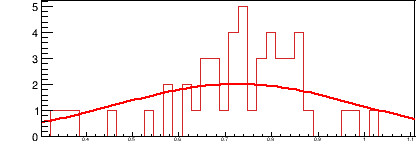

In [20]:
c2 = ROOT.TCanvas("c1", "c1", 420, 180)
c2.SetRightMargin(0.)
c2.SetTopMargin(0.)
modelX = ("", "", nbins, mg.GetXaxis().GetXmin(), mg.GetXaxis().GetXmax())
hX = rdf_energy_pi.Histo1D(modelX, "Snorm_cal")
hX.SetFillStyle(0)
hX.SetLineColor(palette['red'].GetNumber())
# hX.GetXaxis().SetLabelOffset(999)
# hX.GetXaxis().SetLabelSize(0)
hX.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)
rX = hX.Fit("gaus", "S")
hX.SetStats(False)
hX.Draw()
c2.Draw()
c2.Print("hX.png")

 FCN=12.2911 FROM MIGRAD    STATUS=CONVERGED     104 CALLS         105 TOTAL
                     EDM=5.40738e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.05889e+00   4.74021e-01   6.13406e-04  -9.03589e-06
   2  Mean         7.04621e-01   8.01874e-02   1.41636e-04   3.12188e-04
   3  Sigma        3.03344e-01   1.17462e-01   2.25296e-04  -1.20991e-04


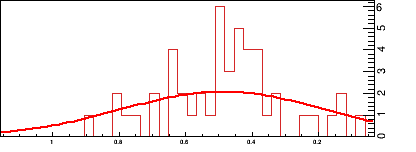

In [21]:
c3 = ROOT.TCanvas("c3", "c3", 420, 180)
c3.SetLeftMargin(0.)
c3.SetTopMargin(0.)
xmin = mg.GetYaxis().GetXmin()
xmax = mg.GetYaxis().GetXmax()
modelY = ("", "", nbins, xmin, xmax)
rdf_energy_pi_rev = rdf_energy_pi
rdf_energy_pi_rev = rdf_energy_pi_rev.Define("reversedCnorm_cal", f"{xmax}-Cnorm_cal+{xmin}")
hY = rdf_energy_pi_rev.Histo1D(modelY, "reversedCnorm_cal")
hY.SetFillStyle(0)
hY.SetLineColor(palette['red'].GetNumber())
hY.GetYaxis().SetLabelSize(mg.GetYaxis().GetLabelSize()*ratio)

rY = hY.Fit("gaus", "S")
hY.SetStats(False)
hY.Draw("Y+")

# Remove the current axis
hY.GetXaxis().SetLabelOffset(999)
hY.GetXaxis().SetTickLength(0)

# Redraw the new axis
ROOT.gPad.Update()
newaxis = ROOT.TGaxis(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(),
                      ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(),
                      xmin, xmax, 510, "-")
newaxis.SetLabelOffset(-0.03)
newaxis.Draw()

ROOT.gPad.Update()
for i in range(7):
    hY.GetYaxis().ChangeLabel(i, 90., -1, 23)
c3.Update()
c3.Draw()
c3.Print("hY.png")

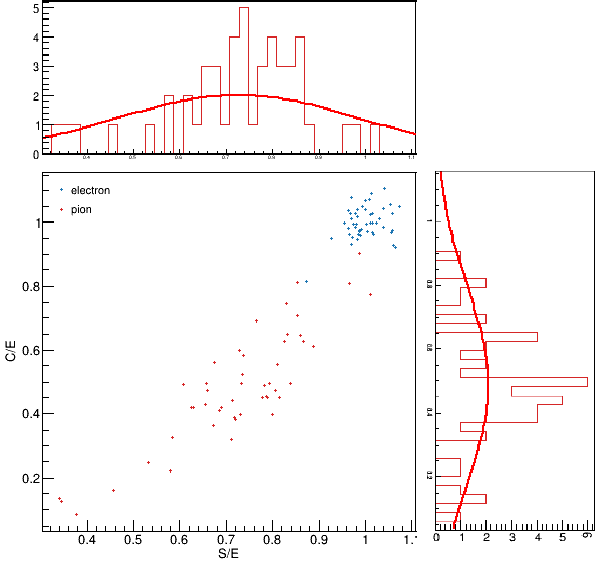

In [22]:
c4 = ROOT.TCanvas("c4", "c4", 600, 600)
pad1 = ROOT.TPad("pad1", "pad1", 0., 0., .7, .7); pad1.Draw()
pad2 = ROOT.TPad("pad2", "pad2", 0., .7, .7, 1.); pad2.Draw()
pad3 = ROOT.TPad("pad3", "pad3", .7, 0., 1., .7); pad3.Draw()
# pad1
pad1.cd()
h_img = ROOT.TImage.Open("hXY.png")
h_img.Draw("x")
pad1.Update()
# pad2
pad2.cd()
hX_img = ROOT.TImage.Open("hX.png")
hX_img.Draw("x")
pad2.Update()
# pad3
pad3.cd()
hY_img = ROOT.TImage.Open("hY.png")
hY_img.Flip(270)
hY_img.Draw("x")
pad3.Update()

c4.Update()
c4.Draw()
c4.Print("final.png")

### Particle identification

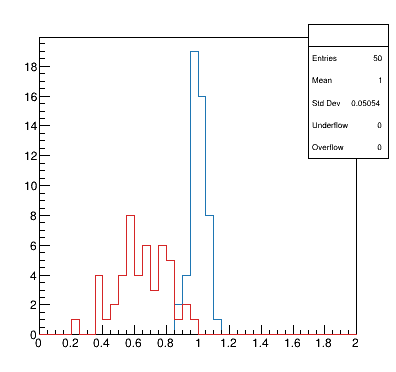

In [23]:
c6 = ROOT.TCanvas("c6", "c6", 400, 400)
model = ("","", 40, 0., 2)
h6_e = rdf_energy_e.Histo1D(model, "CoverS")
h6_pi = rdf_energy_pi.Histo1D(model, "CoverS")
h6_e.SetLineColor(palette['blue'].GetNumber())
h6_pi.SetLineColor(palette['red'].GetNumber())
h6_e.Draw()
h6_pi.Draw("same")
c6.Draw()

## 3. Shower profiles

In [4]:
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/module"

In [5]:
getNij_code = '''
using namespace ROOT::VecOps;
RVec<int> getNi(RVec<int> v, int voxelsAlongY) {
    return v / voxelsAlongY;
};
RVec<int> getNj(RVec<int> v, int voxelsAlongY) {
    return v % voxelsAlongY;
};
'''
ROOT.gInterpreter.Declare(getNij_code)

True

In [6]:
getRadialDistance_code = '''
using namespace ROOT::VecOps;
RVec<double> getRadialDistance(const RVec<double> &x, const RVec<double> &y)
{ 
  auto mod = [](double x, double y) { return sqrt(x * x + y * y); };
  return Map(x, y, mod);
}
'''
ROOT.gInterpreter.Declare(getRadialDistance_code)

True

In [7]:
getArange_code ='''
using namespace ROOT::VecOps;
RVec<int> getArange(const int& a)
{ 
  RVec<int> v(a);
  std::iota(std::begin(v), std::end(v), 0);
  return v;
}
'''
ROOT.gInterpreter.Declare(getArange_code)

True

In [8]:
getRadialProfile_code ='''
using namespace ROOT::VecOps;
RVec<double> getRadialProfile(const RVec<double> &r, const RVec<double> &v1, const RVec<double> &xbins)
{
  double v2 = 0.;
  RVec<double> v(xbins.size());
  RVec<bool> c;
  RVec<double> if_c_v1_else_v2;
  for (size_t i = 0; i<xbins.size()-1; ++i) { 
    c = (r >= xbins.at(i)) && (r < xbins.at(i+1));
    if_c_v1_else_v2 = Where(c, v1, v2);
    v.at(i) = Sum(if_c_v1_else_v2);
  }
  return v;
}
'''
ROOT.gInterpreter.Declare(getRadialProfile_code)

True

In [9]:
# create dataframes
treeName = "B4"
rdf_profile = dict()
for s in ['10GeV', '40GeV']:
    fileName = os.path.join(path, f"{s}/{s}.root")
    rdf_profile[s] = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
    # define new columns
    rdf_profile[s] = rdf_profile[s].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf_profile[s] = rdf_profile[s].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))

In [10]:
for s, v in zip(['10GeV', '40GeV'], ["Scnt", "Ckov"]):
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_i", f"getNi(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_j", f"getNj(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_x", f"{v}_j-VecShower{v}CoMj.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_y", f"{v}_i-VecShower{v}CoMi.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"VecSignal{v}_corr/Sum(VecSignal{v}_corr)")    
#     rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"RVec<double>(VecSignal{v})/Sum(VecSignal{v})")    
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_r_mm", f"1.5*getRadialDistance({v}_x, {v}_y)")

In [11]:
binwidth = 0.6
xlow = 0.
xup = 1.5*np.sqrt(2*8**2)
nbins = int(np.ceil((xup-xlow)/binwidth))
xup = nbins*binwidth
print(nbins, xlow, xup)

29 0.0 17.4


Normalized signal INCLUDING under and overflow

The signal is leakage corrected (normalization makes calibration void)

The radial distance ($r_i$) between each individual fiber 𝑖 and the
shower axis was then determined as Eq. 3 Antonello2018

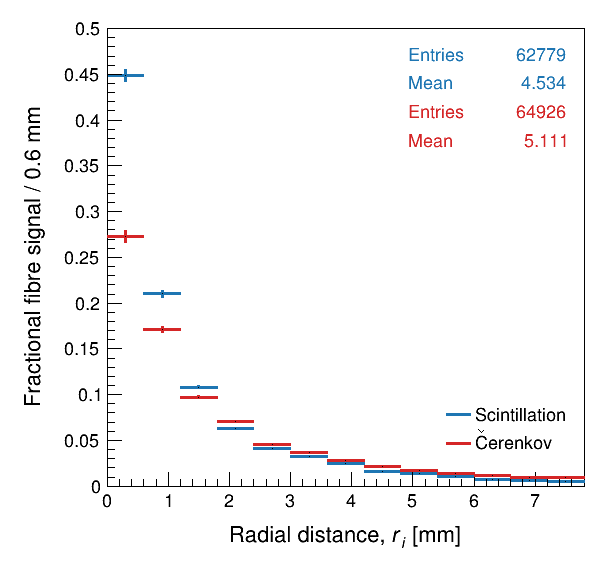

In [38]:
c8 = ROOT.TCanvas("c8", "c8", 600, 600)
ROOT.gStyle.SetOptStat("em")
x = ["Scnt_r_mm", "Ckov_r_mm"]
y = ["Scnt_norm", "Ckov_norm"]
p = [None, None]
model = ("", "", nbins, xlow, xup)
p[0] = rdf_profile['10GeV'].Profile1D(model, x[0], y[0])
p[1] = rdf_profile['40GeV'].Profile1D(model, x[1], y[1])
p[0].Draw()
p[1].Draw("sames")

#
p[0].SetLineColor(palette['blue'].GetNumber())
p[1].SetLineColor(palette['red'].GetNumber())
p[0].GetXaxis().SetTitle("Radial distance, #it{r_{i}} [mm]")
p[0].GetXaxis().SetRangeUser(0., 7.8)
p[0].GetYaxis().SetTitle(f"Fractional fibre signal / {binwidth} mm")
p[0].SetAxisRange(0., 0.5, "Y")

#
ROOT.gPad.SetLeftMargin(0.18)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetRightMargin(0.02)
ROOT.gPad.SetTopMargin(0.05)

labelsize = 1 * p[0].GetYaxis().GetLabelSize()
titlesize = 1.2 * p[0].GetYaxis().GetTitleSize()
xtitleoffset = 1.3 * p[0].GetXaxis().GetTitleOffset()
ytitleoffset = 1.4 * xtitleoffset
xlabeloffset = 2 * p[0].GetXaxis().GetLabelOffset()
ylabeloffset = 2 * p[0].GetYaxis().GetLabelOffset()
linewidth = 3
x2ndc = 0.89+0.08
y2ndc = 0.88+0.05

p[0].SetLineWidth(linewidth)
p[1].SetLineWidth(linewidth)

p[0].GetXaxis().SetTitleSize(titlesize)
p[0].GetXaxis().SetLabelSize(labelsize)
p[0].GetXaxis().CenterTitle()
p[0].GetXaxis().SetTitleOffset(xtitleoffset)
p[0].GetXaxis().SetLabelOffset(xlabeloffset)

p[0].GetYaxis().SetTitleSize(titlesize)
p[0].GetYaxis().SetLabelSize(labelsize)
p[0].GetYaxis().CenterTitle()
p[0].GetYaxis().SetTitleOffset(ytitleoffset)
p[0].GetYaxis().SetLabelOffset(ylabeloffset)

c8.Update()

# stat box
stats1 = p[0].GetListOfFunctions().FindObject("stats")
p[0].GetListOfFunctions().Remove(stats1)
p[0].SetStats(0)
stats1.GetLineWith("Mean y").SetTextColor(0)
stats1.SetTextColor(palette['blue'].GetNumber())
stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.3)
stats1.SetY1NDC(stats1.GetY2NDC()-0.1)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
p[0].SetStats(0)

stats2 = p[1].GetListOfFunctions().FindObject("stats")
p[1].GetListOfFunctions().Remove(stats2)
p[1].SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.1)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.GetListOfLines().Remove(stats2.GetLineWith("Mean y"))
stats2.Draw()
p[1].SetStats(0)

# legend
legend = ROOT.TLegend(stats1.GetX1NDC()+0.07, 0.2, stats1.GetX2NDC(), 0.3)
legend.SetFillColor(0)
#legend.SetTextAlign(ROOT.kHAlignLeft+ROOT.kVAlignTop)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(p[0].GetValue(), "Scintillation", "l")
legend.AddEntry(p[1].GetValue(), "#check{C}erenkov", "l")
legend.Draw()

c8.Modified()

c8.Update()
c8.Draw()
c8.SaveAs("LateralProfile.png")